In [1]:
import os
import glob
import numpy as np
import awkward

In [2]:
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
# import matplotlib
# %matplotlib inline
# import matplotlib.pyplot as plt

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [5]:
# taken from the training outputs -- update if needed
presel_eff = {0: 0.0531643892564612, 1: 0.9818927295320153, 10: 0.9940605634291205, 100: 0.9957324620030694, 1000: 0.9973451587037725}

In [6]:
# FOR NOW, using only one (small) bkg file

sig_filelist = ['/home/pmasterson/ParticleNet/LDMX-scripts/GraphNet/plot_data/v12_training/output_OUTPUT.parquet']
bkg_filelist = glob.glob('/home/pmasterson/ParticleNet/LDMX-scripts/GraphNet/plot_data/v12_large_bkg/output/*_0_*.parquet')

#bkg_filelist = glob.glob('/data/phmaster/ParticleNetData/plot_data/splitnet_extra_in_photon/4gev_1e_ecal_pn_v9_1.8e8eot_20190507_00499f2b_tskim_recon.awkd')
#bkg_filelist = []  # uncomment this if you don't have the extra bkg samples

In [7]:
#sig_tables = [awkward.load(f) for f in sig_filelist]
#bkg_tables = [awkward.load(f) for f in bkg_filelist]
sig_tables = [awkward.from_parquet(f) for f in sig_filelist]
bkg_tables = [awkward.from_parquet(f) for f in bkg_filelist]
print("Loaded")
print("sig_tables:")
print(awkward.type(sig_tables[0]))
print("bkg_tables:")
print(awkward.type(bkg_tables[0]))

Loaded
sig_tables:
156752 * {"TargetSPRecoilE_pt": float64, "EcalVeto_v12.discValue_": float32, "EcalVeto_v12.recoilX_": float32, "EcalVeto_v12.recoilY_": float32, "ParticleNet_extra_label": int32, "ParticleNet_disc": float32}
bkg_tables:
69 * {"TargetSPRecoilE_pt": float64, "EcalVeto_v12.discValue_": float32, "EcalVeto_v12.recoilX_": float32, "EcalVeto_v12.recoilY_": float32, "ParticleNet_disc": float32}


In [8]:
load_branches = [
    'EcalVeto_v12.discValue_',
    'EcalVeto_v12.recoilX_',
    'EcalVeto_v12.recoilY_',
    
    'ParticleNet_extra_label',
    'ParticleNet_disc',
    'TargetSPRecoilE_pt', # use this for plotting: this is the recoil electron pT at TargetSP
]

In [13]:
a = {}
for k in load_branches:
    print("Loading "+k)
    arrs = []
    for tab in sig_tables + bkg_tables:
        #print(awkward.type(tab))
        #print(awkward.fields(tab))
        arr = tab[k] if k in awkward.fields(tab) else np.zeros_like(tab['ParticleNet_disc'])
        arrs.append(arr)
    a[k] = awkward.concatenate(arrs)
    if k.startswith('EcalVeto'):
        #a[k] = a[k].regular()
        a[k] = awkward.to_regular(a[k])
        if a[k].ndim==2 and len(a[k][0]) == 1:  #a[k].shape[1]==1:
            a[k] = a[k][:,0]

t_extra_labels = a['ParticleNet_extra_label']
#print("TESTING")
#print(a['TargetSPRecoilE_pt'][:100])
#print("DONE")
p_rec = a['EcalVeto_v12.recoilX_']
#NEW for finding frac of missing-e events
for k in presel_eff:  #Find the fraction of missing-e events for each signal category
    n_events=0
    n_missing_e=0
    for i in range(len(p_rec)):
        if t_extra_labels[i] == k:
            n_events += 1
            #if i<100:  print(p_rec[i])
            if p_rec[i] == -9999:  n_missing_e += 1
    print("Found", n_events, "events for", k, "MeV")
    print("Fraction of events w/ missing electron for "+str(k)+" MeV is ", str(n_missing_e/n_events))
print("Done")


Loading EcalVeto_v12.discValue_
Loading EcalVeto_v12.recoilX_
Loading EcalVeto_v12.recoilY_
Loading ParticleNet_extra_label
Loading ParticleNet_disc
Loading TargetSPRecoilE_pt
Found 409 events for 0 MeV
Fraction of events w/ missing electron for 0 MeV is  0.06356968215158924
Found 36498 events for 1 MeV
Fraction of events w/ missing electron for 1 MeV is  0.06351032933311414
Found 34863 events for 10 MeV
Fraction of events w/ missing electron for 10 MeV is  0.28110030691564125
Found 26494 events for 100 MeV
Fraction of events w/ missing electron for 100 MeV is  0.36400694496867214
Found 58557 events for 1000 MeV
Fraction of events w/ missing electron for 1000 MeV is  0.38012534795156855
Done


In [14]:
#NEW:  Remove all hits with/without recoilX_==-999 (or -9999?) (or Y)
ntotal = len(a['EcalVeto_v12.recoilX_'])
mask = a['EcalVeto_v12.recoilX_'] != -9999
for k in load_branches:
    a[k] = a[k][mask]
print("Fraction of events without missing electron:", (ntotal-len(a[load_branches[0]]))/len(mask))

#Examine missing electrons in each category:
#NOTE:  uncertain how bkg_tables, etc are structured...
#print(sig_tables[0])

Fraction of events without missing electron: 0.28087437269243276


In [15]:
for k in a.keys():
    print(k, awkward.type(a[k]))
    #NOTE:  elements of dict are just np arrays
    #So...it should be possible to sift everything accordingly.
    
# Full size:  3395546
# Ehit size:  2789329
# Missing e size:  606217 -> Sizes are all consistent

EcalVeto_v12.discValue_ 112774 * float32
EcalVeto_v12.recoilX_ 112774 * float32
EcalVeto_v12.recoilY_ 112774 * float32
ParticleNet_extra_label 112774 * float64
ParticleNet_disc 112774 * float32
TargetSPRecoilE_pt 112774 * float64


In [160]:
def to_categorical(y, num_classes=None):
    """Converts a class vector (integers) to binary class matrix.
    E.g. for use with categorical_crossentropy.
    # Arguments
        y: class vector to be converted into a matrix
            (integers from 0 to num_classes).
        num_classes: total number of classes.
    # Returns
        A binary matrix representation of the input.
    """
    y = np.array(y, dtype='int').ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype='int')
    categorical[np.arange(n), y] = 1
    return categorical


def plotROC(y_preds, y_truth, sample_weight=None, output=None, labels=['signal'], sig_eff=1, bkg_eff=1, energy=0, **kwargs):
    from sklearn.metrics import auc, roc_curve, accuracy_score

    fpr = dict()
    tpr = dict()
    thresholds= dict()
    roc_auc = dict()
    outputs = {}

    plt.figure()

    for label, pred in zip(labels, y_preds):
        print("ytruthlen =", len(y_truth))
        print("predlen =", len(pred))
        print("len sample_weight =", len(sample_weight))
        fpr[label], tpr[label], thresholds[label] = roc_curve(y_truth, pred, sample_weight=sample_weight)
        roc_auc[label] = auc(fpr[label], tpr[label])
        print("**Plotting", len(fpr[label]), "points")
        fpr[label] *= bkg_eff
        tpr[label] *= sig_eff

        legend = '%s (auc* = %0.6f)' % (label, roc_auc[label])
        print(legend)
        eff = get_signal_effs(fpr[label], tpr[label], thresholds[label])
        outputs[label] = eff
        print(eff)
        print("**Plotting", len(fpr[label]), "events")
        plt.plot(fpr[label], tpr[label], label=legend)
#     plt.plot([0, 1], [1, 0], 'k--')
    plt.xlim(kwargs.get('xlim', [0, 1]))
    plt.ylim(kwargs.get('ylim', [0, 1]))
    plt.xlabel('False positive rate ($\epsilon_{B}$)')
    plt.ylabel('True positive rate ($\epsilon_{S}$)')
#     plt.title('Receiver operating characteristic example')
    plt.legend(loc='best')
    if kwargs.get('logy', False):
        plt.yscale('log')
    if kwargs.get('logx', False):
        plt.xscale('log')
    plt.grid()
    # TEMPORARY TITLE
    plt.title("Events with SP hit, "+str(k)+" MeV", fontdict = {'fontsize' : 15})
    #plt.title("All events, "+str(k)+" MeV", fontdict = {'fontsize' : 15})
    if output:
        plt.savefig(output)
#     return {'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds}
    return outputs

mistags=[1e-3, 1e-4, 1e-5, 1e-6]
def get_signal_effs(fpr, tpr, thresholds, mistags=mistags):
    outputs = []
    for m in mistags:
        idx = next(idx for idx, v in enumerate(fpr) if v > m)
        outputs.append((fpr[idx], tpr[idx], thresholds[idx]))
    return outputs


In [161]:
test_extra_labels = a['ParticleNet_extra_label']
test_labels = test_extra_labels>0

1 MeV


<IPython.core.display.Javascript object>


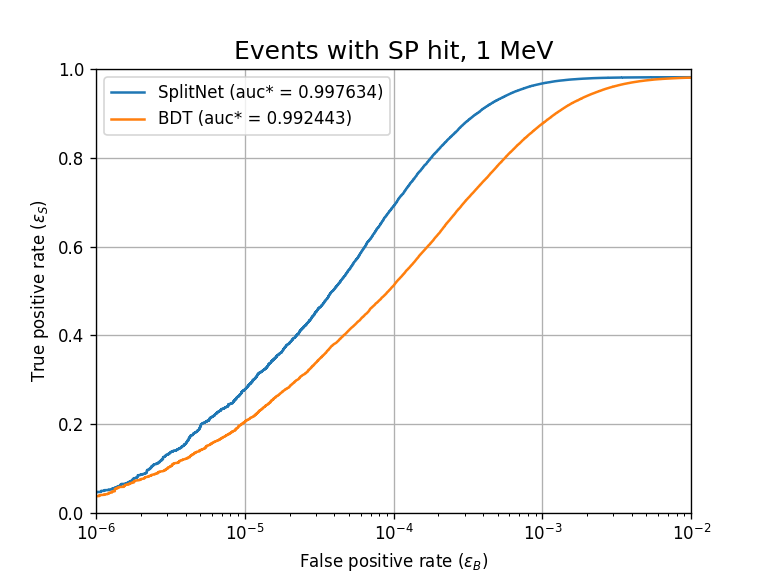

ytruthlen = 4057055
predlen = 4057055
len sample_weight = 4057055
**Plotting 657279 points
SplitNet (auc* = 0.997634)
[(0.0010000585868422587, 0.9677729765288396, 0.5020601), (0.00010002294688699699, 0.6911415946074428, 0.82338893), (1.0025078959061203e-05, 0.27768847572912125, 0.91672814), (1.025292166267623e-06, 0.04633954079575449, 0.9671622)]
**Plotting 657279 events
ytruthlen = 4057055
predlen = 4057055
len sample_weight = 4057055
**Plotting 541624 points
BDT (auc* = 0.992443)
[(0.001000001626166355, 0.8771829136525955, 0.9824594), (0.00010002294688699699, 0.511762842996689, 0.9989573), (1.0025078959061203e-05, 0.2040191048908055, 0.99984753), (1.025292166267623e-06, 0.03708098108524333, 0.99996483)]
**Plotting 541624 events
10 MeV


<IPython.core.display.Javascript object>


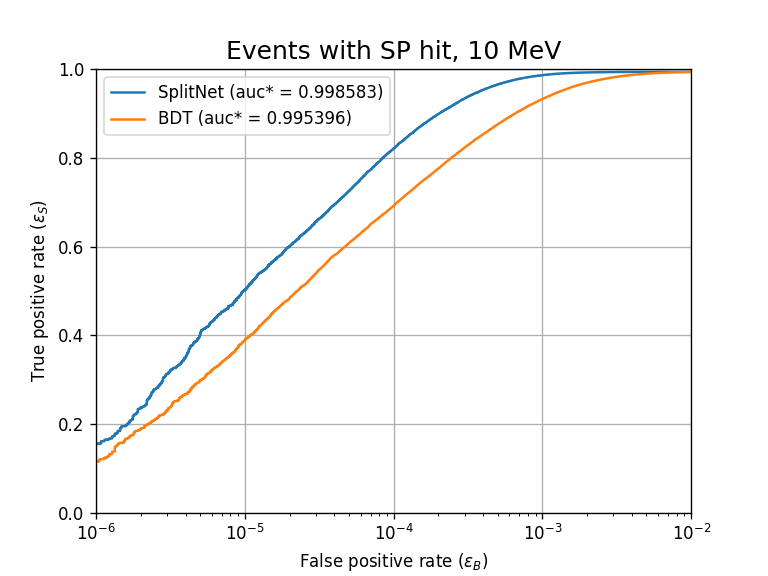

ytruthlen = 4057055
predlen = 4057055
len sample_weight = 4057055
**Plotting 742198 points
SplitNet (auc* = 0.998583)
[(0.0010000585868422587, 0.9862918196714835, 0.5020601), (0.00010002294688699699, 0.8205411896347466, 0.82338893), (1.0025078959061203e-05, 0.5019380361845289, 0.91672814), (1.025292166267623e-06, 0.15506860736998612, 0.9671622)]
**Plotting 742198 events
ytruthlen = 4057055
predlen = 4057055
len sample_weight = 4057055
**Plotting 539996 points
BDT (auc* = 0.995396)
[(0.001000001626166355, 0.9325903784468181, 0.9824594), (0.00010002294688699699, 0.6916721725909964, 0.9989573), (1.0025078959061203e-05, 0.38804128074804517, 0.99984753), (1.025292166267623e-06, 0.11487780833408288, 0.99996483)]
**Plotting 539996 events
100 MeV


<IPython.core.display.Javascript object>


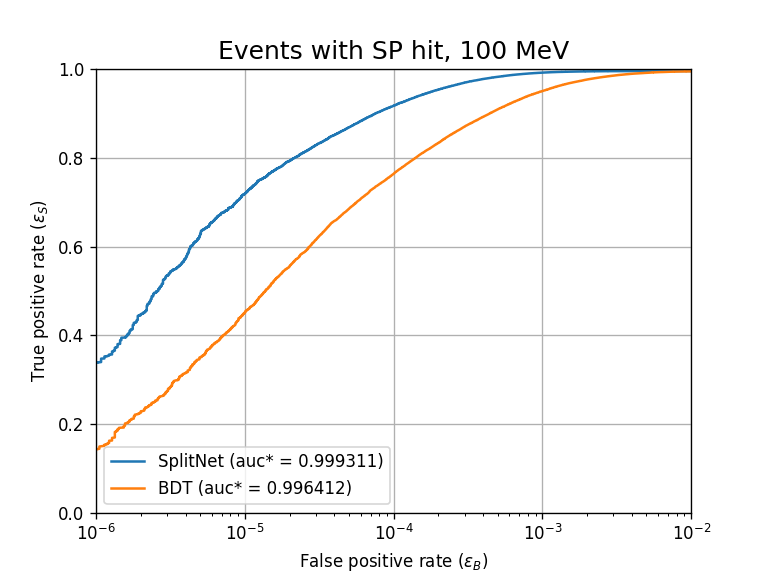

ytruthlen = 4057055
predlen = 4057055
len sample_weight = 4057055
**Plotting 616070 points
SplitNet (auc* = 0.999311)
[(0.0010000585868422587, 0.9920843823776305, 0.5020601), (0.00010002294688699699, 0.9173253254706234, 0.82338893), (1.0025078959061203e-05, 0.7191548755658224, 0.91672814), (1.025292166267623e-06, 0.33813591018306344, 0.9671622)]
**Plotting 616070 events
ytruthlen = 4057055
predlen = 4057055
len sample_weight = 4057055
**Plotting 522640 points
BDT (auc* = 0.996412)
[(0.001000001626166355, 0.9504721151799091, 0.9824594), (0.00010002294688699699, 0.7637677486541364, 0.9989573), (1.0025078959061203e-05, 0.4503711334144466, 0.99984753), (1.025292166267623e-06, 0.14306753593327132, 0.99996483)]
**Plotting 522640 events
1000 MeV


<IPython.core.display.Javascript object>


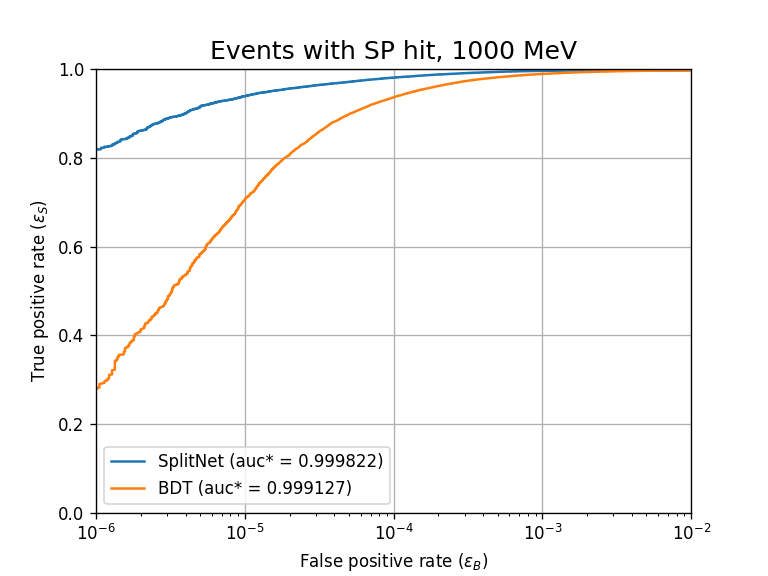

ytruthlen = 4057055
predlen = 4057055
len sample_weight = 4057055
**Plotting 499510 points
SplitNet (auc* = 0.999822)
[(0.0010000585868422587, 0.9961214279574998, 0.5020601), (0.00010002294688699699, 0.9807971906799271, 0.82338893), (1.0025078959061203e-05, 0.9389649212218159, 0.91672814), (1.025292166267623e-06, 0.8186758692564319, 0.9671622)]
**Plotting 499510 events
ytruthlen = 4057055
predlen = 4057055
len sample_weight = 4057055
**Plotting 504509 points
BDT (auc* = 0.999127)
[(0.001000001626166355, 0.9892022887003791, 0.9824594), (0.00010002294688699699, 0.9362966361359581, 0.9989573), (1.0025078959061203e-05, 0.704648086259759, 0.99984753), (1.025292166267623e-06, 0.2804229610490678, 0.99996483)]
**Plotting 504509 events


In [162]:
roc_info = {}
for k in presel_eff:
    if k > 0:
        mass = '%d MeV' % k
        print(mass)
        roc_info[k] = plotROC([a['ParticleNet_disc'], a['EcalVetoGabriel_recon.discValue_']], test_labels, 
                sample_weight=np.logical_or(test_extra_labels == 0, test_extra_labels == k),
                sig_eff=presel_eff[k], bkg_eff=presel_eff[0],
                labels=['SplitNet', 'BDT'], xlim=[1e-6, .01], ylim=[0, 1], logx=True, energy=k)
        #**NOTE:**  The sample_weight line is critical!!  Selects only bkg+sig[k].

In [163]:
roc_info

{1: {'SplitNet': [(0.0010000585868422587, 0.9677729765288396, 0.5020601),
   (0.00010002294688699699, 0.6911415946074428, 0.82338893),
   (1.0025078959061203e-05, 0.27768847572912125, 0.91672814),
   (1.025292166267623e-06, 0.04633954079575449, 0.9671622)],
  'BDT': [(0.001000001626166355, 0.8771829136525955, 0.9824594),
   (0.00010002294688699699, 0.511762842996689, 0.9989573),
   (1.0025078959061203e-05, 0.2040191048908055, 0.99984753),
   (1.025292166267623e-06, 0.03708098108524333, 0.99996483)]},
 10: {'SplitNet': [(0.0010000585868422587, 0.9862918196714835, 0.5020601),
   (0.00010002294688699699, 0.8205411896347466, 0.82338893),
   (1.0025078959061203e-05, 0.5019380361845289, 0.91672814),
   (1.025292166267623e-06, 0.15506860736998612, 0.9671622)],
  'BDT': [(0.001000001626166355, 0.9325903784468181, 0.9824594),
   (0.00010002294688699699, 0.6916721725909964, 0.9989573),
   (1.0025078959061203e-05, 0.38804128074804517, 0.99984753),
   (1.025292166267623e-06, 0.11487780833408288, 0

In [164]:
plot_bins = {
#     'EcalVetoGabriel_recon.nReadoutHits_':np.linspace(0, 50, 51),
#     'EcalVetoGabriel_recon.deepestLayerHit_':np.linspace(0, 35, 36),
#     'EcalVetoGabriel_recon.summedDet_':np.linspace(0, 2000, 41),
#     'EcalVetoGabriel_recon.summedTightIso_':np.linspace(0, 400, 41),
#     'EcalVetoGabriel_recon.maxCellDep_':np.linspace(0, 400, 41),
#     'EcalVetoGabriel_recon.showerRMS_':np.linspace(0, 250, 26),
#     'EcalVetoGabriel_recon.xStd_':np.linspace(0, 200, 41),
#     'EcalVetoGabriel_recon.yStd_':np.linspace(0, 200, 41),
#     'EcalVetoGabriel_recon.avgLayerHit_':np.linspace(0, 35, 36),
#     'EcalVetoGabriel_recon.stdLayerHit_':np.linspace(0, 20, 21),
#     'EcalVetoGabriel_recon.ecalBackEnergy_':np.linspace(0, 200, 41),
# #     'EcalVetoGabriel_recon.discValue_':np.linspace(0.9, 1, 51),
#     'EcalVetoGabriel_recon.recoilX_':np.linspace(-400, 400, 81),
#     'EcalVetoGabriel_recon.recoilY_':np.linspace(-400, 400, 81),

    'TargetSPRecoilE_pt':np.linspace(-50, 200, 51),

#     'ParticleNet_disc':np.linspace(0, 1, 51),
}

# plot_bins = {
#     'EcalVetoGabriel_recon.ecalLayerEdepReadout_:%d'%i:np.linspace(0, 1000, 51) for i in range(34)
# }


In [165]:
colors = ['#636363', '#74c476', '#3182bd', '#f03b20', '#bd0026']
colors = None

In [166]:
def plot_sig_vs_bkg(var_name):
    if ':' in var_name:
        var, var_idx = var_name.split(':')
        var_idx = int(var_idx)
    else:
        var, var_idx = var_name, None

    arrays = []
    labels = []
    for proc in presel_eff.keys():
        pos = test_extra_labels==proc
        arr = a[var][pos]
        if var_idx:
            arr = arr[:, var_idx]
        if not isinstance(plot_bins[var_name], int):
            arr = np.clip(arr, min(plot_bins[var_name]), max(plot_bins[var_name]))
        arrays.append(arr)
        labels.append('BKG' if proc==0 else '%d MeV'%proc)
    f = plt.figure()
    #TEMP TITLE
    #plt.title("Events without SP hit")
    plt.title("All events")
    #NOTE:  normed=True caused an error; removing it temporarily
    plt.hist(arrays, bins=plot_bins[var_name], label=labels, histtype='step', log=True)
    plt.legend()
    plt.xlabel(var_name)

In [167]:
# plot_sig_vs_bkg('TargetSPRecoilE_pt')

TargetSPRecoilE_pt


<IPython.core.display.Javascript object>


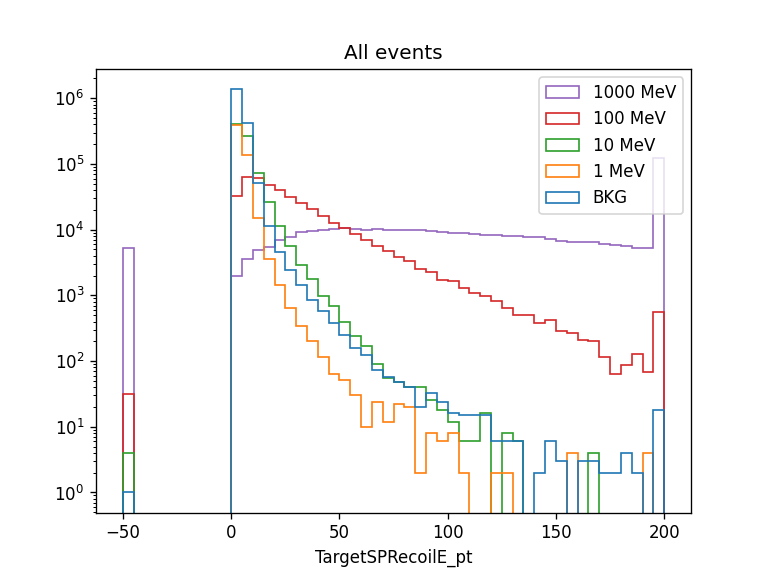

In [168]:
for var in plot_bins:
    print(var)
    plot_sig_vs_bkg(var)

In [169]:
def plot_trend(var_name, proc, eff_levels=None, mistag_levels=[1e-3, 1e-4, 1e-5, 1e-6]):
    if ':' in var_name:
        var, var_idx = var_name.split(':')
        var_idx = int(var_idx)
    else:
        var, var_idx = var_name, None
    if eff_levels is None and mistag_levels is None:
        eff_levels = [1e-3, 1e-4, 1e-5, 1e-6] if proc==0 else [0.9, 0.7, 0.5, 0.2]
    f, axes = plt.subplots(1, 2, figsize=(12, 5))
    f.suptitle('%d MeV'%proc if proc>0 else 'BKG', fontsize=16)
    pos0 = test_extra_labels==proc
    a_tmp = {k:a[k][pos0] for k in ('ParticleNet_disc', 'EcalVetoGabriel_recon.discValue_', var)}
    if var_idx:
        a_tmp[var] = a_tmp[var][:, var_idx]
    for i, k in enumerate(['ParticleNet_disc', 'EcalVetoGabriel_recon.discValue_']):
        arrs = []
        labels = []
        scores = a_tmp[k]
        if mistag_levels is None:  #NOTE:  Currently modifying this to produce fixed bkg efficiencies...
            #Changing presel_eff[proc] to 1 (Warning:  bkg will be messed up)
            pcts = (1 - np.array(eff_levels)/presel_eff[1]) * 100.
            print('effs=', pcts)
            thresholds = [-99] + list(np.percentile(scores, pcts))
        else:
            thresholds = [-99] + [info[-1] for info in roc_info[1]['SplitNet' if i==0 else 'BDT']]
        print(k, thresholds)
        for idx, thres in enumerate(thresholds):
            pos = scores>thres
#             print(k, thres, pos.sum())
            if not isinstance(plot_bins[var_name], int):
                arrs.append(np.clip(a_tmp[var][pos], min(plot_bins[var_name]), max(plot_bins[var_name])))
            else:
                arrs.append(a_tmp[var][pos])
            if mistag_levels is None:
                labels.append('inclusive' if idx==0 else ('$\epsilon_{B}$=%.0e'%eff_levels[idx-1] if proc==0 else '$\epsilon_{S}$=%.1f'%eff_levels[idx-1]))
            else:
                labels.append('inclusive' if idx==0 else '$\epsilon_{B}$=%.0e'%mistag_levels[idx-1])

        axes[i].hist(arrs, histtype='step', bins=plot_bins[var_name], density=True, log=True, label=labels, color=colors, linewidth=2)
        axes[i].set_title('SplitNet, events with SP hit' if i==0 else 'BDT')  #, '+str(proc if proc>0 else 'BKG')+' MeV
        axes[i].set_xlabel(var)
        axes[i].set_ylim(1e-6, 30)
        axes[i].legend(loc='best')

TargetSPRecoilE_pt


<IPython.core.display.Javascript object>


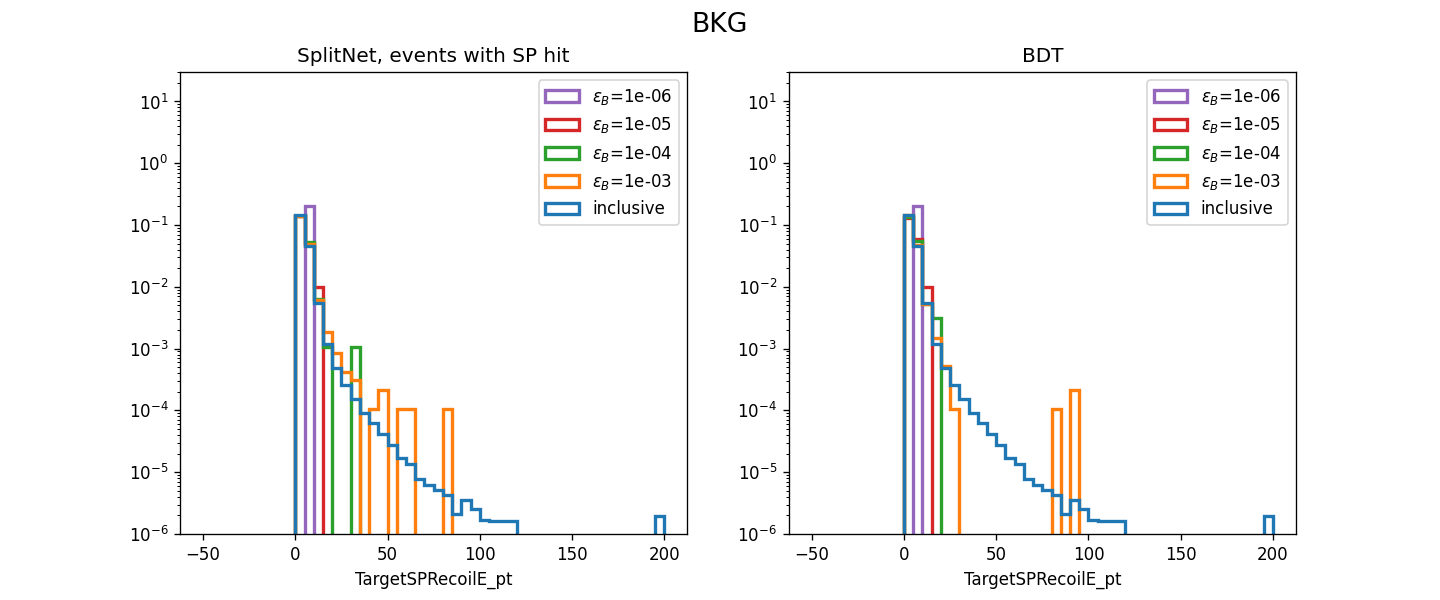

effs= [99.89815588 99.98981559 99.99898156 99.99989816]
ParticleNet_disc [-99, 0.85802454051715, 0.9327717878777637, 0.9755396999111019, 0.9996514249426737]
effs= [99.89815588 99.98981559 99.99898156 99.99989816]
EcalVetoGabriel_recon.discValue_ [-99, 0.9993990353957901, 0.99989837988647, 0.9999759918588222, 0.9999914169311523]


<IPython.core.display.Javascript object>


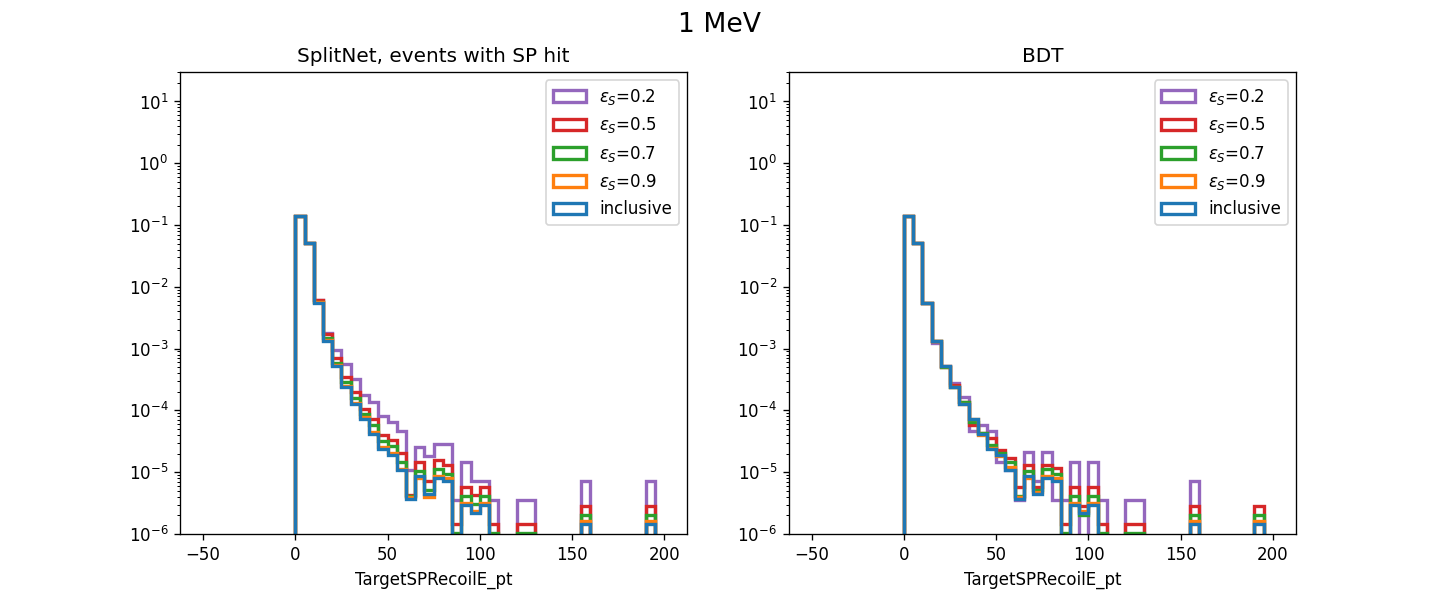

effs= [ 8.34029289 28.70911669 49.0779405  79.6311762 ]
ParticleNet_disc [-99, 0.6997424364089966, 0.820381224155426, 0.8723124265670776, 0.9336159229278564]
effs= [ 8.34029289 28.70911669 49.0779405  79.6311762 ]
EcalVetoGabriel_recon.discValue_ [-99, 0.9755043983459473, 0.9965643286705017, 0.999030590057373, 0.9998517036437988]


<IPython.core.display.Javascript object>


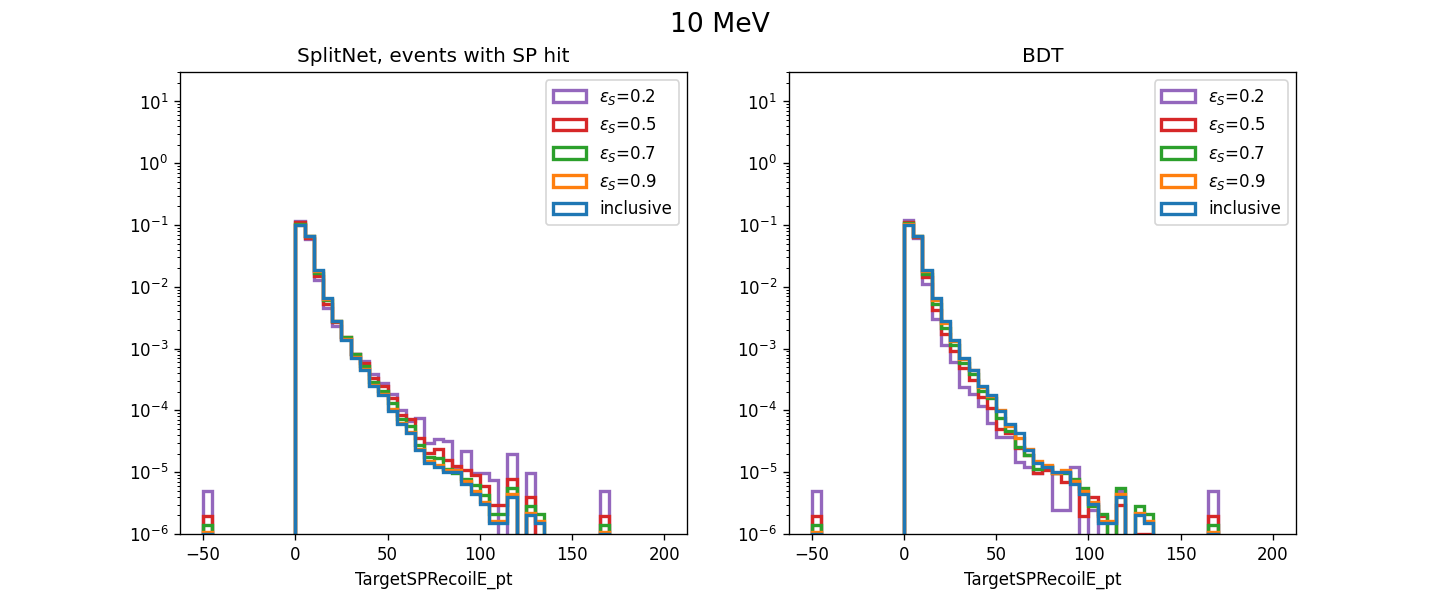

effs= [ 8.34029289 28.70911669 49.0779405  79.6311762 ]
ParticleNet_disc [-99, 0.7549259662628174, 0.8670543881054191, 0.9158889537873066, 0.9613020420074463]
effs= [ 8.34029289 28.70911669 49.0779405  79.6311762 ]
EcalVetoGabriel_recon.discValue_ [-99, 0.9886000752449036, 0.9988092184066772, 0.9997069239616394, 0.9999393224716187]


<IPython.core.display.Javascript object>


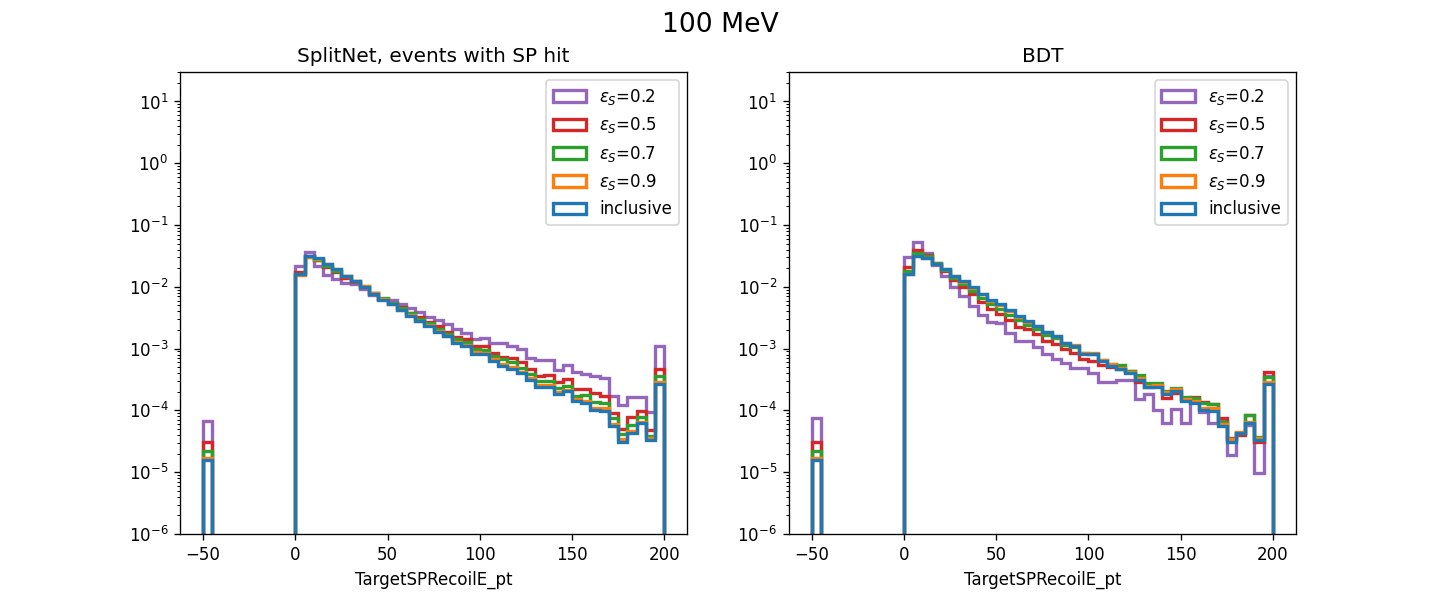

effs= [ 8.34029289 28.70911669 49.0779405  79.6311762 ]
ParticleNet_disc [-99, 0.82813960313797, 0.9189510345458984, 0.9514085054397583, 0.9789912715065989]
effs= [ 8.34029289 28.70911669 49.0779405  79.6311762 ]
EcalVetoGabriel_recon.discValue_ [-99, 0.9930667877197266, 0.9993312358856201, 0.9998000264167786, 0.9999501705169678]


<IPython.core.display.Javascript object>


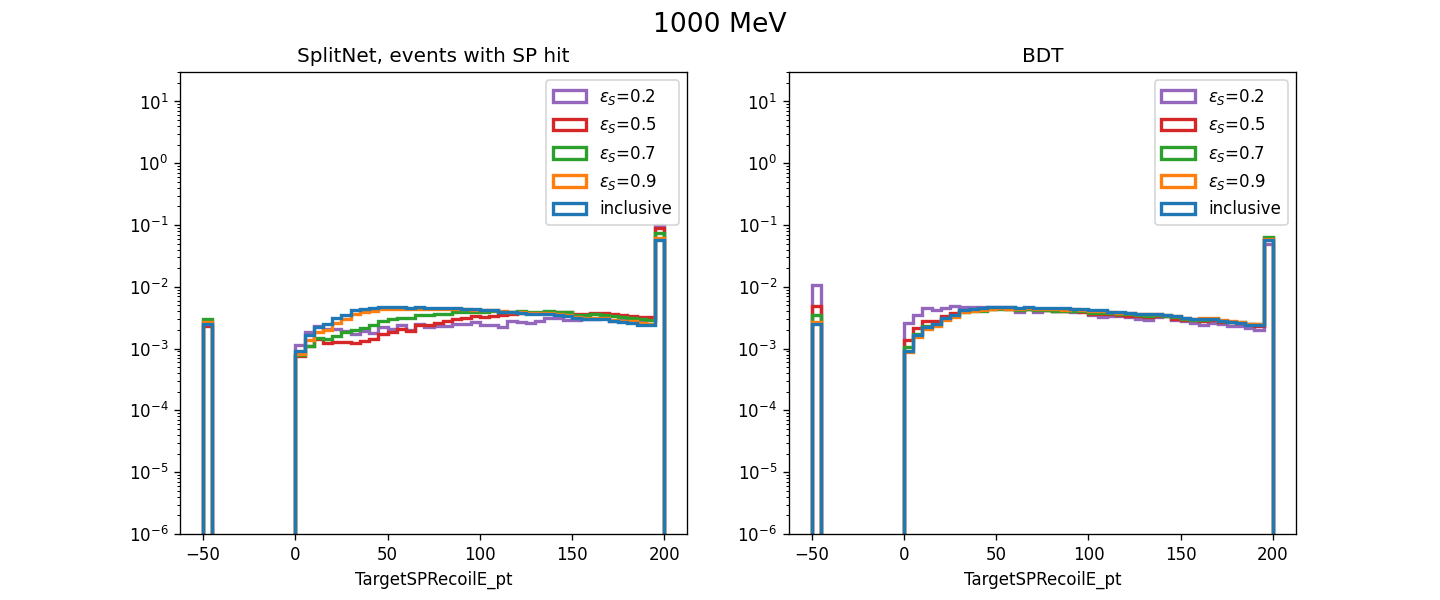

effs= [ 8.34029289 28.70911669 49.0779405  79.6311762 ]
ParticleNet_disc [-99, 0.9356263419316196, 0.9819998489793278, 0.9968177080154419, 0.9998859167098999]
effs= [ 8.34029289 28.70911669 49.0779405  79.6311762 ]
EcalVetoGabriel_recon.discValue_ [-99, 0.9992983341217041, 0.9998432397842407, 0.999923586845398, 0.9999752044677734]


In [170]:
# compare shapes with succesively tighter selections
# keep BKG mistag rate the same for all signal points

for var in plot_bins:
    print(var)
    plot_trend(var, proc=0, mistag_levels=None)
    plot_trend(var, proc=1, mistag_levels=None)
    plot_trend(var, proc=10, mistag_levels=None)
    plot_trend(var, proc=100, mistag_levels=None)
    plot_trend(var, proc=1000, mistag_levels=None)

TargetSPRecoilE_pt


<IPython.core.display.Javascript object>


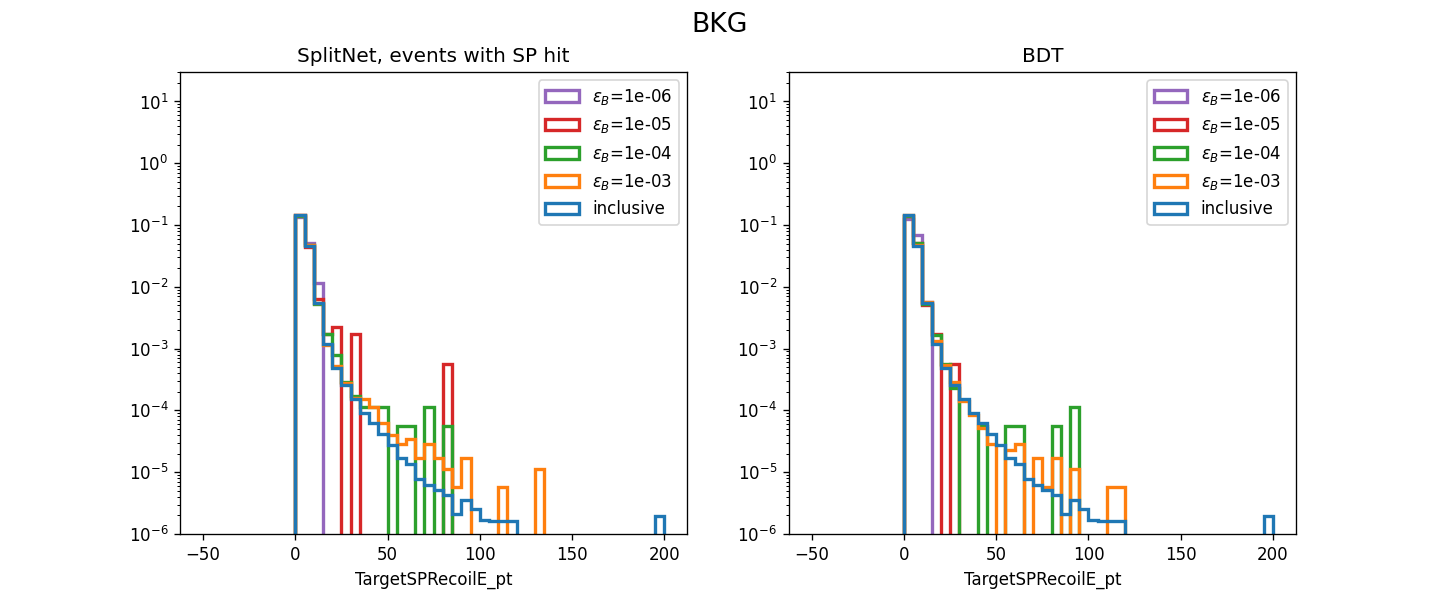

ParticleNet_disc [-99, 0.5020601, 0.82338893, 0.91672814, 0.9671622]
EcalVetoGabriel_recon.discValue_ [-99, 0.9824594, 0.9989573, 0.99984753, 0.99996483]


<IPython.core.display.Javascript object>


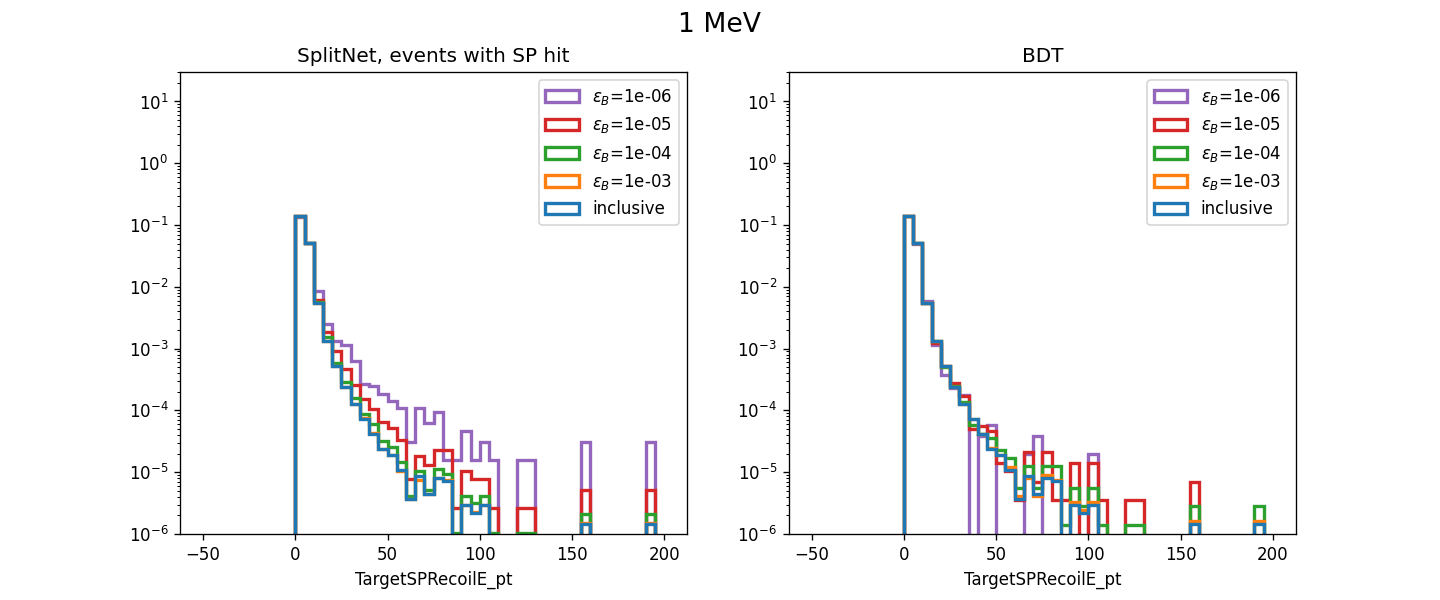

ParticleNet_disc [-99, 0.5020601, 0.82338893, 0.91672814, 0.9671622]
EcalVetoGabriel_recon.discValue_ [-99, 0.9824594, 0.9989573, 0.99984753, 0.99996483]


<IPython.core.display.Javascript object>


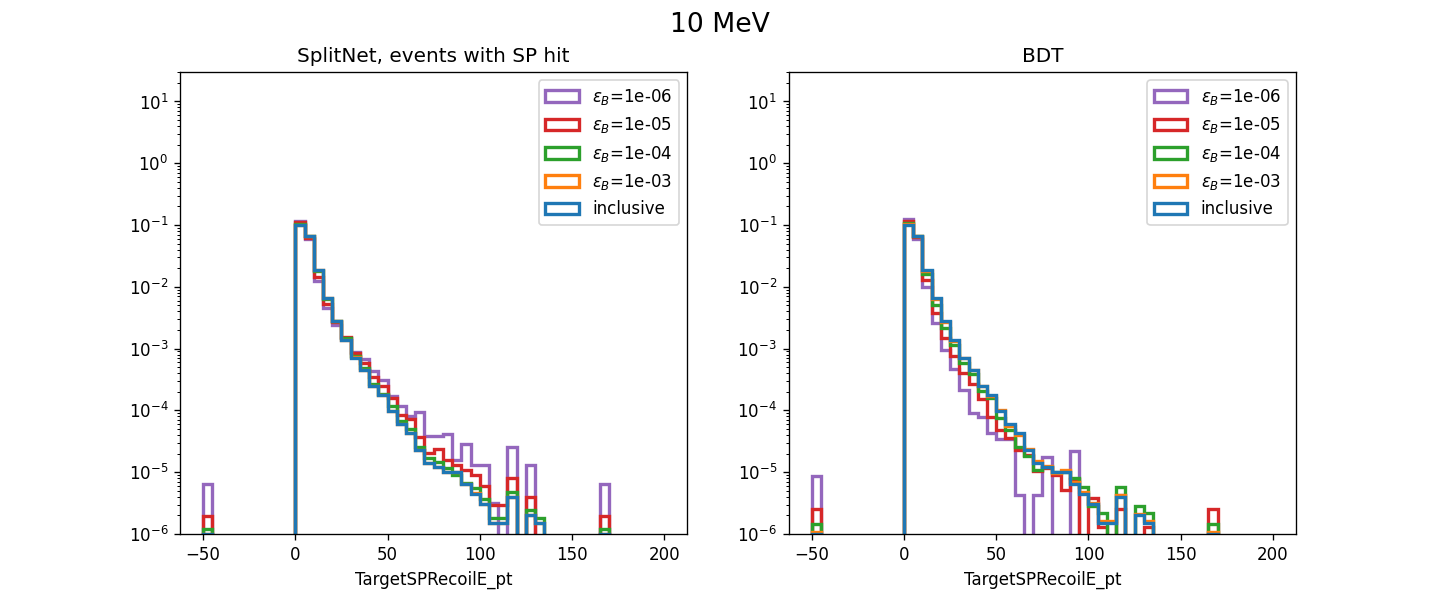

ParticleNet_disc [-99, 0.5020601, 0.82338893, 0.91672814, 0.9671622]
EcalVetoGabriel_recon.discValue_ [-99, 0.9824594, 0.9989573, 0.99984753, 0.99996483]


<IPython.core.display.Javascript object>


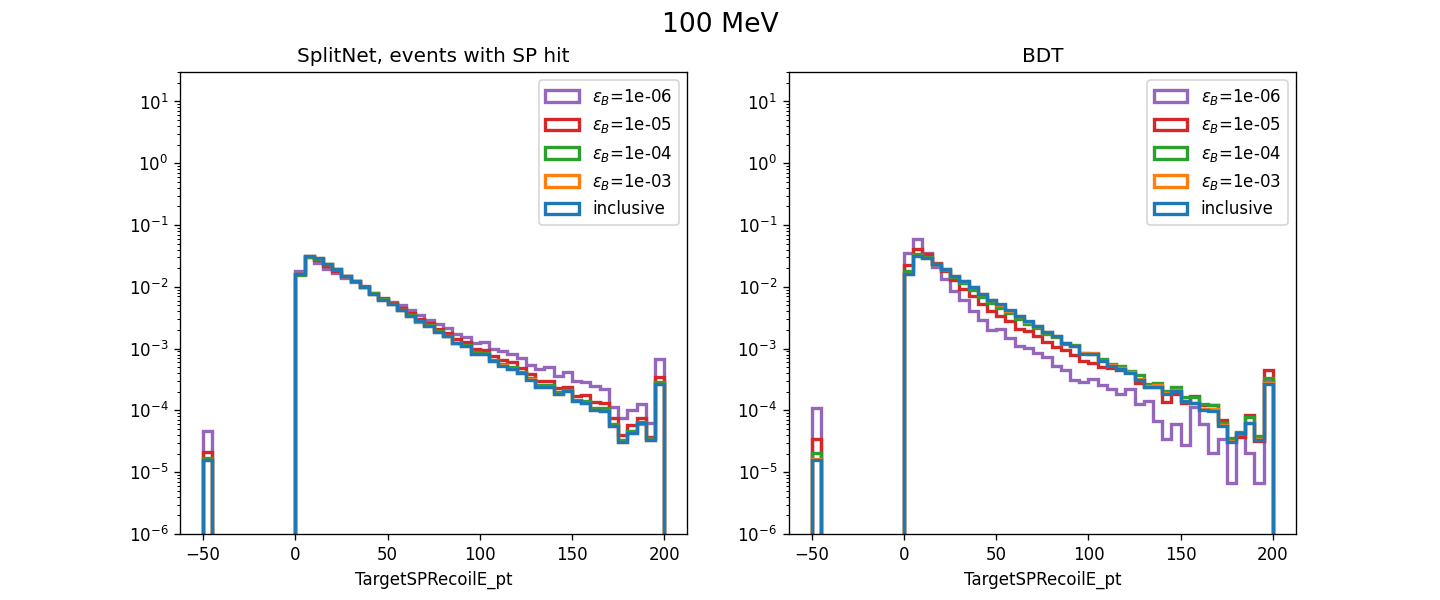

ParticleNet_disc [-99, 0.5020601, 0.82338893, 0.91672814, 0.9671622]
EcalVetoGabriel_recon.discValue_ [-99, 0.9824594, 0.9989573, 0.99984753, 0.99996483]


<IPython.core.display.Javascript object>


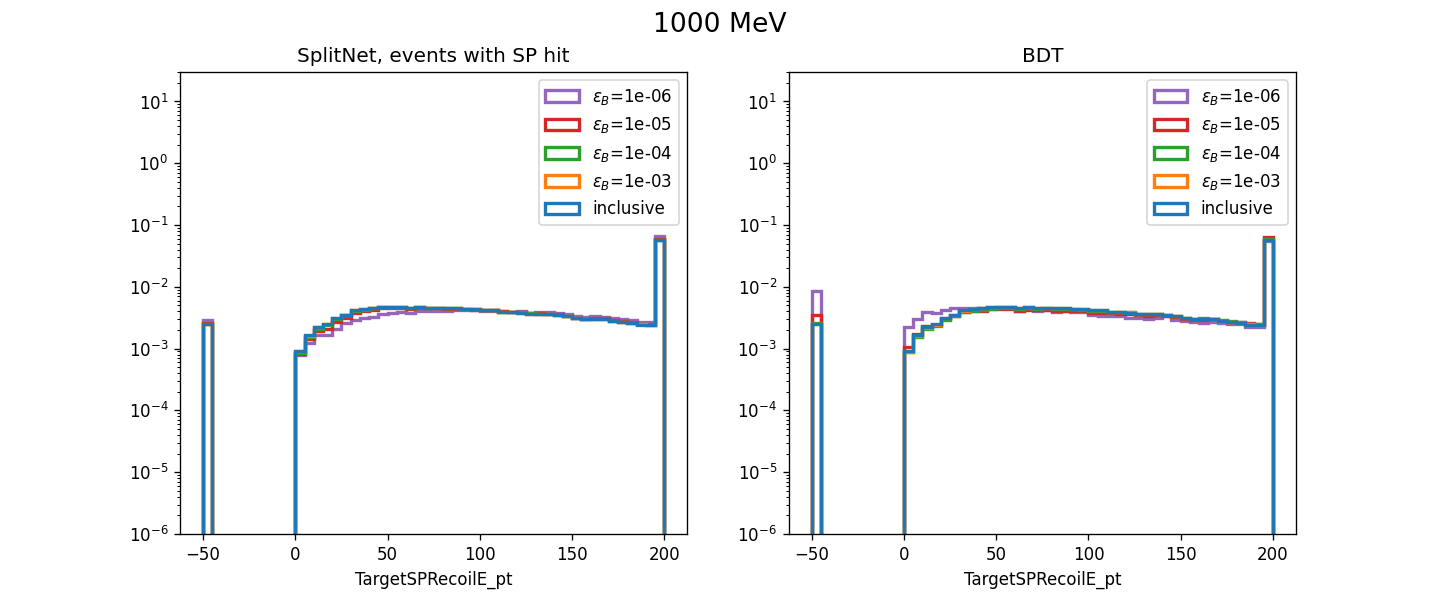

ParticleNet_disc [-99, 0.5020601, 0.82338893, 0.91672814, 0.9671622]
EcalVetoGabriel_recon.discValue_ [-99, 0.9824594, 0.9989573, 0.99984753, 0.99996483]


In [171]:
# compare shapes with succesively tighter selections
# keep SIG efficiency the same for all signal points

for var in plot_bins:
    print(var)
    plot_trend(var, proc=0)
    plot_trend(var, proc=1)
    plot_trend(var, proc=10)
    plot_trend(var, proc=100)
    plot_trend(var, proc=1000)
    
# All:  pT bias still visible in 10MeV
# SP hit:  pT bias mostly gone
# No SP hit:  no pT bias, as usual